This notebook demonstrates how to analyze the impact of CVSS and EPSS scores on the time it takes to patch vulnerabilities. By stratifying the vulnerabilities into high and low groups based on these scores, we can visually compare their survival functions, offering insights into how severity and exploitability predictions influence patching priorities and timelines.

For a more sophisticated analysis that quantitatively assesses the impact of these factors (and potentially others, like the presence of an exploit), a Cox Proportional Hazards model could be employed. This model would allow for the estimation of hazard ratios for each covariate, providing a more detailed understanding of their influence on patch times.

In [1]:
# Required libraries
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
# Step 1: Data Preparation
# Simulate vulnerability data with detection and patch dates, CVSS, and EPSS scores
np.random.seed(42)
num_vulns = 100
detection_dates = [datetime.now() - timedelta(days=np.random.randint(1, 365)) for _ in range(num_vulns)]
patch_times = np.random.normal(loc=30, scale=10, size=num_vulns).astype(int)
patch_dates = [d + timedelta(days=int(pt)) if np.random.rand() > 0.1 else pd.NaT for d, pt in zip(detection_dates, patch_times)]
cvss_scores = np.random.uniform(0, 10, size=num_vulns)
epss_scores = np.random.uniform(0, 1, size=num_vulns)
exploit_exists = np.random.choice([True, False], size=num_vulns, p=[0.3, 0.7])

In [4]:
df = pd.DataFrame({'detection_date': detection_dates, 'patch_date': patch_dates, 'cvss_score': cvss_scores,
                   'epss_score': epss_scores, 'exploit_exists': exploit_exists})
df['time_to_patch'] = (df['patch_date'] - df['detection_date']).dt.days

In [5]:
# Step 2: Stratify Data Based on CVSS and EPSS Scores
# Stratify based on CVSS score (High: > 7, Low: <= 7) and EPSS score (High: >= 0.5, Low: < 0.5)
high_cvss = df[df['cvss_score'] > 7]
low_cvss = df[df['cvss_score'] <= 7]
high_epss = df[df['epss_score'] >= 0.5]
low_epss = df[df['epss_score'] < 0.5]

In [6]:
# Step 3: Perform Kaplan-Meier Analysis for Each Stratified Group
def plot_km_curve(data, label, ax=None):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=data['time_to_patch'].fillna(365), event_observed=~data['patch_date'].isna(), label=label)
    kmf.plot_survival_function(ax=ax)

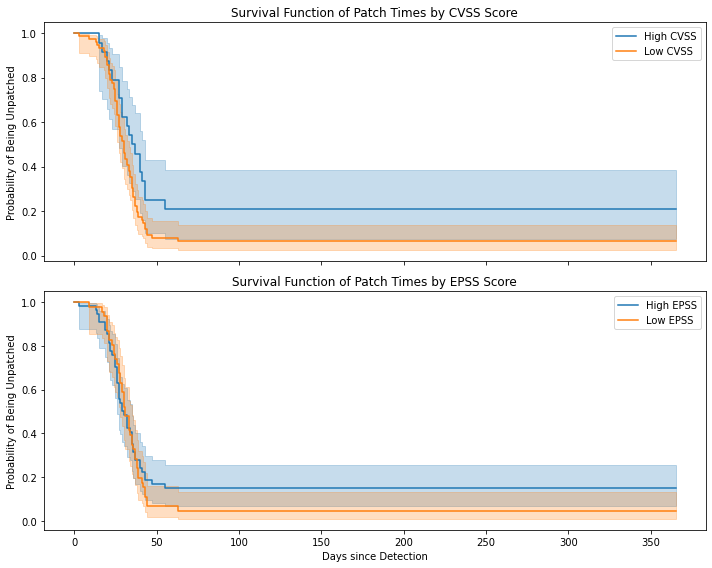

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

plot_km_curve(high_cvss, 'High CVSS', ax=ax[0])
plot_km_curve(low_cvss, 'Low CVSS', ax=ax[0])
ax[0].set_title('Survival Function of Patch Times by CVSS Score')
ax[0].set_xlabel('Days since Detection')
ax[0].set_ylabel('Probability of Being Unpatched')

plot_km_curve(high_epss, 'High EPSS', ax=ax[1])
plot_km_curve(low_epss, 'Low EPSS', ax=ax[1])
ax[1].set_title('Survival Function of Patch Times by EPSS Score')
ax[1].set_xlabel('Days since Detection')
ax[1].set_ylabel('Probability of Being Unpatched')

plt.tight_layout()
plt.show()